<a href="https://colab.research.google.com/github/AashiDutt/Pytorch/blob/master/Image_Recognition_in_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this repository we will look through Image Recognition using Pytorch using MNIST dataset and using validation datset.

softmax activation function capable of dealing with multiclass datasets

## MNIST dataset is input to neural network in form of pixels i.e(28 X 28 = 784 pixels).

1. Therefore our input nodes of neural network must be equal to 784 nodes.

2.while the output classify numbers between 0 to 9 therefore no. of output nodes = 10

## Split large dataset into training and test dataset
  
 **Generalization** - the ability to correctly classify data which has never been seen before and has no labels.
  
he more minimized the training error the greater will be the test error
  
 small training error = underfitting
  
 gap between test and training error grows larger = overfitting
  
** Underfitting** - model with insufficient capacity are unable to solve complex tasks.

**Overfitting **- when model performs better on train data than test data
  
**Reducing overfitting **
1. Reduce depth and complexity of model
2. reduce no. of nodes
3. reduce no. of epochs

**Generalization error** (also known as the out-of-sample error) is a measure of how accurately an algorithm is able to predict outcome values for previously unseen data.
  
**Regularization** - helps to reduce Generalization error.

In [1]:
# CODE

# Loading Images and Transforms

!pip3 install torch torchvision

In [0]:
import torch
from torchvision import datasets, transforms

# transformations are used to preprocess the dataset before it is fed to neural network
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [0]:
transform = transforms.Compose([transforms.Resize((28,28)),transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
#Compose allows us to chain together transformations

#we chose value 0.5 because we want values in range 0 to 1,creating a range (-1 to 1)

# Normalizing the image 
# formula z = (x - mean)/ standard deviation
# eg. (min value - mean)/standard deviation = (0-0.5)/0.5 = -1
# (max value- mean)/sd = (1-0.5)/0.5 =1  therefore range = (-1,1)

#Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) = Normalize(mean,standard deviation)
#Normalize the value of each tensor of image size channel height and widthin 1st set of brackets
#converts numpy array(of range 0-255) to tensor (a float tensor in range 0 to 1)

# defining root directory of training_dataset
training_dataset = datasets.MNIST(root ='./data', train = True, download = True,transform =transform )
validation_dataset = datasets.MNIST(root ='./data', train = False, download = True,transform =transform )


training_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size = 100, shuffle = True)
validation_loader =torch.utils.data.DataLoader(dataset = training_dataset, batch_size = 100, shuffle = False)

In [0]:
# to plot an image convert it again to a numpy array
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  # clone to create new copy of tensor
  # use detach function to call numpy
  
  image = image.transpose(1,2,0)
  # we have shape of tensor as(1,28,28)(single colorchannel,shape(28,28)) but to plot a grayscale image we need tensor of shape (28,28,1)
  # we swap axis using transpose means swap axis 0 for axis 1, axis 1 fo axis 2 and axis 0 in the end
  #print(image.shape)
  # denormalizing the image
  # x=z * standard deviation + mean
  
  image = image *np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
  image = image.clip(0,1)
  # to reconvert range from (-1,1) to (1,1) we use clip function
  return image


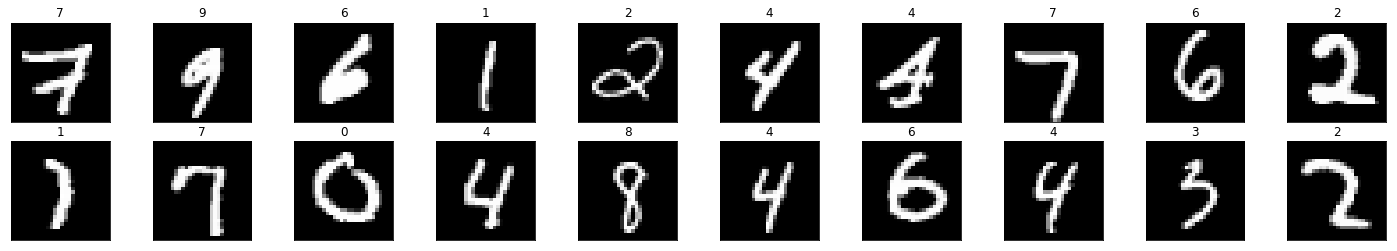

In [5]:
# creating a iterator 
# iter creates an object that allows us to go through the iterable of training loader one element at a time 
dataiter = iter(training_loader)
images , labels = dataiter.next()
#images, labels = dataiter.next() # gets first batch of training data
fig = plt.figure(figsize =(25,4))

for idx in np.arange(20):
  ax =fig.add_subplot(2,10,idx+1,xticks =[],yticks =[])   # 2 rows 10 columns per row and index
  plt.imshow(im_convert(images[idx]))
  ax.set_title(labels[idx].item())

In [0]:
class Classifier(nn.Module): # classifying layer by layer
  def __init__(self, D_in , H1,H2, D_out):
    super().__init__()
    self.linear1 = nn.Linear(D_in,H1)
    self.linear2 = nn.Linear(H1,H2)
    self.linear3 = nn.Linear(H2,D_out)
  
  def forward(self,x):
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = self.linear3(x)
    return x
  

In [7]:
model = Classifier(784, 125,65,10)  # classifier(no. of pixels that must be fed at input, no. of nodes at hidden layer 1,no. of nodes at hidden layer2,output size = no. of classes 0 to9)
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [0]:
# Loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [12]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
 
for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.view(inputs.shape[0], -1)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
 
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.view(val_inputs.shape[0], -1)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.1201, acc 96.5067 
validation loss: 0.1136, validation acc 96.7067 
epoch : 2
training loss: 0.1141, acc 96.6750 
validation loss: 0.1095, validation acc 96.9267 
epoch : 3
training loss: 0.1086, acc 96.8533 
validation loss: 0.1072, validation acc 96.8883 
epoch : 4
training loss: 0.1035, acc 96.9433 
validation loss: 0.1035, validation acc 97.0183 
epoch : 5
training loss: 0.0982, acc 97.1267 
validation loss: 0.0927, validation acc 97.3483 
epoch : 6
training loss: 0.0935, acc 97.3050 
validation loss: 0.0882, validation acc 97.4117 
epoch : 7
training loss: 0.0895, acc 97.3950 
validation loss: 0.0837, validation acc 97.5533 
epoch : 8
training loss: 0.0850, acc 97.5067 
validation loss: 0.0812, validation acc 97.6883 
epoch : 9
training loss: 0.0814, acc 97.6433 
validation loss: 0.0771, validation acc 97.7500 
epoch : 10
training loss: 0.0782, acc 97.6767 
validation loss: 0.0744, validation acc 97.8883 
epoch : 11
training loss: 0.0747, acc 97.8133 
va

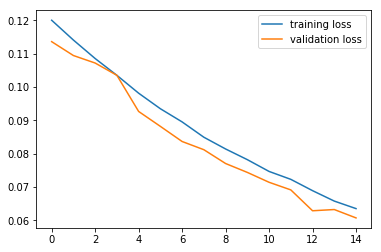

In [13]:
plt.plot(running_loss_history, label = 'training loss')
plt.plot(val_running_loss_history, label= 'validation loss')
plt.legend()

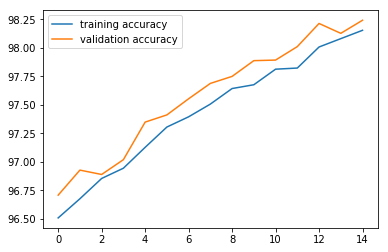

In [14]:
plt.plot(running_corrects_history ,label ='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [0]:
import PIL.ImageOps

<Response [200]>


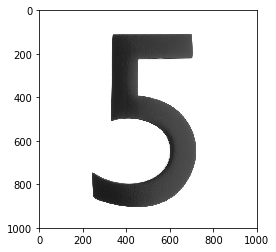

In [29]:
import requests
from PIL import Image
url ='https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url,stream = True)
img = Image.open(response.raw)
plt.imshow(img)
print(response)

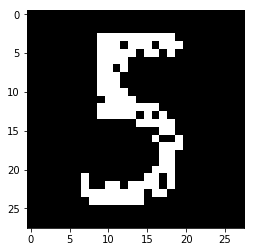

In [30]:
# the model is trained on black background and white image
# above image is reverse ..converting above image to desired form

img = PIL.ImageOps.invert(img)
img = img.convert('1')
img =transform(img)
plt.imshow(im_convert(img))

In [31]:
img = img.view(img.shape[0], -1)
output = model(img)
_,pred = torch.max(output, 1)
print(pred.item())

5


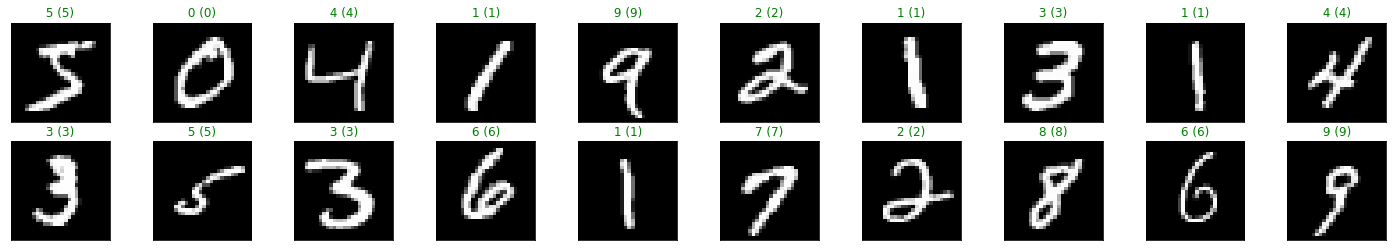

In [40]:
# creating a iterator 
# iter creates an object that allows us to go through the iterable of training loader one element at a time 
dataiter = iter(validation_loader)
images , labels = dataiter.next()
#images, labels = dataiter.next() # gets first batch of training data
images_ = images.view(images.shape[0] ,-1)

output = model(images_)
_,preds = torch.max(output, 1)


fig = plt.figure(figsize =(25,4))

for idx in np.arange(20):
  ax =fig.add_subplot(2,10,idx+1,xticks =[],yticks =[])   # 2 rows 10 columns per row and index
  plt.imshow(im_convert(images[idx]))
  ax.set_title(" {} ({}) ".format(str(preds[idx].item()),str(labels[idx].item())), color= "green" if preds[idx]==labels[idx] else "red")